In [14]:
# https://keras.io/
#!pip install -q keras
import keras

In [15]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate, SpatialDropout2D
from keras.optimizers import Adam, SGD
from keras.initializers import he_normal, random_normal
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
import keras.backend as K
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import plot_model
import numpy as np

In [16]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

In [32]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 150
l = 12
num_filter = 24
compression = 0.5
dropout_rate = 0.2
wt_decay = 0.001

In [18]:
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoing 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [19]:
train_datagen = ImageDataGenerator(
        #rotation_range=40,
        width_shift_range=0.1,
        height_shift_range=0.1,
        #shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        #brightness_range=[0.1, 0.5],
        #channel_shift_range=0.5,
        fill_mode='nearest',
        featurewise_center=True,
        featurewise_std_normalization=True)

In [20]:
test_datagen = ImageDataGenerator(
        #rotation_range=40,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        #shear_range=0.2,
        #zoom_range=0.2,
        #horizontal_flip=True,
        #brightness_range=[0.1, 0.5],
        #channel_shift_range=0.5,
        #fill_mode='nearest',
        featurewise_center=True,
        featurewise_std_normalization=True)

In [21]:
#x_train = x_train.astype('float32')
train_datagen.fit(x_train)
test_datagen.fit(x_test)
#x_train = ImageDataGenerator.standardize(datagen,x_train)
#x_test = x_test.astype('float32')
#datagen.fit(x_test)
#x_test = ImageDataGenerator.standardize(datagen,x_test)

In [22]:
# Dense Block
def add_denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        #Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same', kernel_initializer=(random_normal(stddev=np.sqrt(2.0/(9*int(num_filter*compression))))))(relu)
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same',kernel_regularizer=l2(wt_decay) , kernel_initializer=(random_normal(stddev=np.sqrt(2.0/(9*int(num_filter))))))(relu)
        if dropout_rate>0:
          Conv2D_3_3 = SpatialDropout2D(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

In [26]:
def add_transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(int(input.shape[-1])*compression), (1,1), use_bias=False ,padding='same',kernel_regularizer=l2(wt_decay) , kernel_initializer=(random_normal(stddev=np.sqrt(2.0/(9*int(num_filter*compression))))))(relu)
    #Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same',kernel_initializer=(random_normal(stddev=np.sqrt(2.0/(9*int(num_filter*compression))))))(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = SpatialDropout2D(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [24]:
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    flat = Flatten()(AvgPooling)
    output = Dense(num_classes, activation='softmax', kernel_regularizer=l2(wt_decay))(flat)
    #output = Dense(num_classes, activation='softmax', kernel_initializer='he_normal')(flat)
    
    return output

In [33]:
input = Input(shape=(img_height, img_width, channel,))
First_Conv2D = Conv2D(int(num_filter), (3,3), use_bias=False , padding='same', kernel_regularizer=l2(wt_decay), kernel_initializer=(random_normal(stddev=np.sqrt(2.0/(9*num_filter)))))(input)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

#First_Transition = merge([First_Transition,First_Conv2D], mode='concat', concat_axis=-1)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

#Second_Transition = Concatenate(axis=-1)([Second_Transition,First_Transition,First_Conv2D])

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

#Third_Transition = Concatenate(axis=-1)([Third_Transition,Second_Transition,First_Transition,First_Conv2D])

Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)


In [34]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_146 (Conv2D)             (None, 32, 32, 24)   648         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_144 (BatchN (None, 32, 32, 24)   96          conv2d_146[0][0]                 
__________________________________________________________________________________________________
activation_144 (Activation)     (None, 32, 32, 24)   0           batch_normalization_144[0][0]    
__________________________________________________________________________________________________
conv2d_147

In [35]:
def step_down_20(epochs, crate):
    if ((epochs != 0) and (epochs%20 == 0)):
        crate = crate * 0.8
    return crate

In [36]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
       self.losses = []
       self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
       optimizer = self.model.optimizer
       lr_temp = step_down_20(optimizer.iterations,optimizer.lr)
       self.losses.append(logs.get('loss'))
       self.lr.append(lr_temp)

In [37]:
sgd = SGD(lr=0.1, decay=1e-4, momentum=0.9, nesterov=True)

In [38]:
K.get_value(sgd.lr)

0.1

In [39]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [40]:
#loss_history = LossHistory()
#lrate = LearningRateScheduler(step_down_20, verbose=1)
#reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='auto', min_lr=1e-4, verbose=1)
#early = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, mode='auto', verbose=1)
#callbacks_list = [reduce, early]

In [41]:
checkpoint_vl = ModelCheckpoint("weights.best_vl.hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint_va = ModelCheckpoint("weights.best_va.hdf5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint_va, checkpoint_vl]

Epoch 1/150
391/390 [==============================] - 81s 207ms/step - loss: 6.7131 - acc: 0.3157 - val_loss: 3.8114 - val_acc: 0.3568

Epoch 00001: val_acc improved from -inf to 0.35680, saving model to weights.best_va.hdf5

Epoch 00001: val_loss improved from inf to 3.81144, saving model to weights.best_vl.hdf5
Epoch 2/150
391/390 [==============================] - 63s 162ms/step - loss: 2.6932 - acc: 0.4452 - val_loss: 2.2666 - val_acc: 0.4136

Epoch 00002: val_acc improved from 0.35680 to 0.41360, saving model to weights.best_va.hdf5

Epoch 00002: val_loss improved from 3.81144 to 2.26663, saving model to weights.best_vl.hdf5
Epoch 3/150
391/390 [==============================] - 62s 159ms/step - loss: 1.8387 - acc: 0.5045 - val_loss: 1.6909 - val_acc: 0.5157

Epoch 00003: val_acc improved from 0.41360 to 0.51570, saving model to weights.best_va.hdf5

Epoch 00003: val_loss improved from 2.26663 to 1.69088, saving model to weights.best_vl.hdf5
Epoch 4/150
391/390 [=================

Epoch 30/150
391/390 [==============================] - 63s 161ms/step - loss: 1.1498 - acc: 0.7423 - val_loss: 1.1718 - val_acc: 0.7343

Epoch 00030: val_acc did not improve from 0.74650

Epoch 00030: val_loss did not improve from 1.12438
Epoch 31/150
391/390 [==============================] - 63s 161ms/step - loss: 1.1490 - acc: 0.7404 - val_loss: 1.2977 - val_acc: 0.6947

Epoch 00031: val_acc did not improve from 0.74650

Epoch 00031: val_loss did not improve from 1.12438
Epoch 32/150
391/390 [==============================] - 63s 160ms/step - loss: 1.1468 - acc: 0.7401 - val_loss: 1.1623 - val_acc: 0.7406

Epoch 00032: val_acc did not improve from 0.74650

Epoch 00032: val_loss did not improve from 1.12438
Epoch 33/150
391/390 [==============================] - 63s 161ms/step - loss: 1.1409 - acc: 0.7425 - val_loss: 1.1872 - val_acc: 0.7310

Epoch 00033: val_acc did not improve from 0.74650

Epoch 00033: val_loss did not improve from 1.12438
Epoch 34/150
391/390 [==================


Epoch 00061: val_acc did not improve from 0.80130

Epoch 00061: val_loss did not improve from 0.96929
Epoch 62/150
391/390 [==============================] - 63s 160ms/step - loss: 1.0185 - acc: 0.7806 - val_loss: 1.0656 - val_acc: 0.7728

Epoch 00062: val_acc did not improve from 0.80130

Epoch 00062: val_loss did not improve from 0.96929
Epoch 63/150
391/390 [==============================] - 63s 160ms/step - loss: 1.0080 - acc: 0.7875 - val_loss: 1.0155 - val_acc: 0.7867

Epoch 00063: val_acc did not improve from 0.80130

Epoch 00063: val_loss did not improve from 0.96929
Epoch 64/150
391/390 [==============================] - 63s 160ms/step - loss: 1.0078 - acc: 0.7857 - val_loss: 0.9829 - val_acc: 0.7967

Epoch 00064: val_acc did not improve from 0.80130

Epoch 00064: val_loss did not improve from 0.96929
Epoch 65/150
391/390 [==============================] - 63s 162ms/step - loss: 1.0086 - acc: 0.7839 - val_loss: 0.9721 - val_acc: 0.7999

Epoch 00065: val_acc did not improve fr


Epoch 00094: val_acc did not improve from 0.81890

Epoch 00094: val_loss did not improve from 0.89042
Epoch 95/150
391/390 [==============================] - 63s 160ms/step - loss: 0.9157 - acc: 0.8084 - val_loss: 0.9520 - val_acc: 0.7976

Epoch 00095: val_acc did not improve from 0.81890

Epoch 00095: val_loss did not improve from 0.89042
Epoch 96/150
391/390 [==============================] - 63s 160ms/step - loss: 0.9120 - acc: 0.8094 - val_loss: 0.9150 - val_acc: 0.8125

Epoch 00096: val_acc did not improve from 0.81890

Epoch 00096: val_loss did not improve from 0.89042
Epoch 97/150
391/390 [==============================] - 63s 160ms/step - loss: 0.9089 - acc: 0.8100 - val_loss: 1.0070 - val_acc: 0.7774

Epoch 00097: val_acc did not improve from 0.81890

Epoch 00097: val_loss did not improve from 0.89042
Epoch 98/150
391/390 [==============================] - 63s 160ms/step - loss: 0.9132 - acc: 0.8098 - val_loss: 1.0349 - val_acc: 0.7695

Epoch 00098: val_acc did not improve fr

391/390 [==============================] - 63s 161ms/step - loss: 0.8454 - acc: 0.8262 - val_loss: 0.8332 - val_acc: 0.8315

Epoch 00127: val_acc did not improve from 0.83730

Epoch 00127: val_loss did not improve from 0.81334
Epoch 128/150
391/390 [==============================] - 63s 160ms/step - loss: 0.8461 - acc: 0.8240 - val_loss: 0.8449 - val_acc: 0.8250

Epoch 00128: val_acc did not improve from 0.83730

Epoch 00128: val_loss did not improve from 0.81334
Epoch 129/150
391/390 [==============================] - 63s 161ms/step - loss: 0.8430 - acc: 0.8235 - val_loss: 0.8586 - val_acc: 0.8187

Epoch 00129: val_acc did not improve from 0.83730

Epoch 00129: val_loss did not improve from 0.81334
Epoch 130/150
391/390 [==============================] - 63s 161ms/step - loss: 0.8421 - acc: 0.8229 - val_loss: 0.8218 - val_acc: 0.8346

Epoch 00130: val_acc did not improve from 0.83730

Epoch 00130: val_loss did not improve from 0.81334
Epoch 131/150
391/390 [===========================

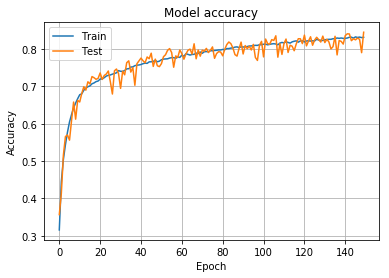

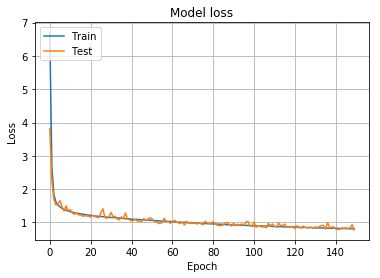

In [42]:
#history = model.fit(x_train, y_train, batch_size=batch_size, epochs=150, verbose=1, validation_data=(x_test, y_test), callbacks=callbacks_list)
history = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=batch_size), 
                              steps_per_epoch=len(x_train) / batch_size, 
                              epochs=epochs, verbose=1,
                              validation_data=train_datagen.flow(x_test, y_test, batch_size=batch_size),
                              validation_steps=len(x_test) / batch_size,
                              callbacks=callbacks_list)

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.show()

# Plot loss history
#plt.plot(loss_history.lr)
#plt.title('loss history')
#plt.ylabel('loss')
#plt.xlabel('Epoch')
#plt.grid()
#plt.show()


In [43]:
# Test the model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 8s 831us/step
Test loss: 12.912266191101073
Test accuracy: 0.1386


In [44]:
model.save_weights("weights.150_epochs_1st.hdf5")
print("loaded model from disk best va")

loaded model from disk best va


In [49]:
model.load_weights("weights.150_epochs_1st.hdf5")
print("loaded model from disk 150 epochs")

loaded model from disk 150 epochs


In [50]:
#K.set_value(model.optimizer.lr, 0.001)
print('learning rate after best vl is: ', K.get_value(sgd.lr))
K.set_value(sgd.lr, 0.01)
print('setting new learning rate: ', K.get_value(sgd.lr))

learning rate after best vl is:  0.2
setting new learning rate:  0.01


In [51]:
checkpoint_vl1 = ModelCheckpoint("weights.best_vl1.hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint_va1 = ModelCheckpoint("weights.best_va1.hdf5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list1 = [checkpoint_va1, checkpoint_vl1]

Epoch 1/50
391/390 [==============================] - 64s 163ms/step - loss: 0.7458 - acc: 0.8508 - val_loss: 0.7114 - val_acc: 0.8636

Epoch 00001: val_acc improved from 0.84500 to 0.86360, saving model to weights.best_va.hdf5

Epoch 00001: val_loss improved from 0.77477 to 0.71144, saving model to weights.best_vl.hdf5
Epoch 2/50
391/390 [==============================] - 64s 164ms/step - loss: 0.6945 - acc: 0.8703 - val_loss: 0.6834 - val_acc: 0.8729

Epoch 00002: val_acc improved from 0.86360 to 0.87290, saving model to weights.best_va.hdf5

Epoch 00002: val_loss improved from 0.71144 to 0.68343, saving model to weights.best_vl.hdf5
Epoch 3/50
391/390 [==============================] - 64s 165ms/step - loss: 0.6683 - acc: 0.8757 - val_loss: 0.6614 - val_acc: 0.8788

Epoch 00003: val_acc improved from 0.87290 to 0.87880, saving model to weights.best_va.hdf5

Epoch 00003: val_loss improved from 0.68343 to 0.66139, saving model to weights.best_vl.hdf5
Epoch 4/50
391/390 [==============


Epoch 00029: val_acc did not improve from 0.90020

Epoch 00029: val_loss improved from 0.51267 to 0.51224, saving model to weights.best_vl.hdf5
Epoch 30/50
391/390 [==============================] - 67s 170ms/step - loss: 0.4750 - acc: 0.9063 - val_loss: 0.5029 - val_acc: 0.8984

Epoch 00030: val_acc did not improve from 0.90020

Epoch 00030: val_loss improved from 0.51224 to 0.50290, saving model to weights.best_vl.hdf5
Epoch 31/50
391/390 [==============================] - 67s 172ms/step - loss: 0.4709 - acc: 0.9061 - val_loss: 0.5017 - val_acc: 0.8992

Epoch 00031: val_acc did not improve from 0.90020

Epoch 00031: val_loss improved from 0.50290 to 0.50174, saving model to weights.best_vl.hdf5
Epoch 32/50
391/390 [==============================] - 67s 172ms/step - loss: 0.4731 - acc: 0.9055 - val_loss: 0.5030 - val_acc: 0.8965

Epoch 00032: val_acc did not improve from 0.90020

Epoch 00032: val_loss did not improve from 0.50174
Epoch 33/50
391/390 [==============================] -

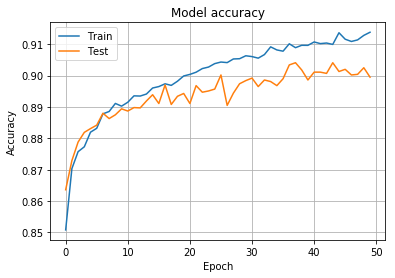

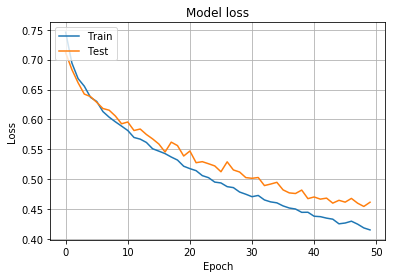

In [52]:
#history = model.fit(x_train, y_train, batch_size=batch_size, epochs=50, initial_epoch=30, verbose=1, validation_data=(x_test, y_test), callbacks=callbacks_list1)
history = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=batch_size), 
                              steps_per_epoch=len(x_train) / batch_size, 
                              epochs=50,
                              verbose=1, validation_data=train_datagen.flow(x_test, y_test, batch_size=batch_size),
                              validation_steps=len(x_test) / batch_size,
                              callbacks=callbacks_list)

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.show()

In [53]:
# Test the model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 8s 835us/step
Test loss: 10.905716748046874
Test accuracy: 0.1598


In [54]:
model.save_weights("weights.50_epochs_2st.hdf5")
print("saved model")

saved model


In [58]:
model.load_weights("weights.50_epochs_2st.hdf5")
print("loaded model from disk best va1")

loaded model from disk best va1


In [59]:
#K.set_value(model.optimizer.lr, 0.001)
print('learning rate after va1 is: ', K.get_value(sgd.lr))
K.set_value(sgd.lr, 0.0001)
print('setting new learning rate: ', K.get_value(sgd.lr))

learning rate after va1 is:  0.001
setting new learning rate:  1e-04


In [60]:
checkpoint_vl2 = ModelCheckpoint("weights.best_vl2.hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint_va2 = ModelCheckpoint("weights.best_va2.hdf5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list2 = [checkpoint_va2, checkpoint_vl2]

Epoch 1/50
391/390 [==============================] - 63s 160ms/step - loss: 0.4152 - acc: 0.9147 - val_loss: 0.4458 - val_acc: 0.9046

Epoch 00001: val_acc did not improve from 0.91470

Epoch 00001: val_loss did not improve from 0.41789
Epoch 2/50
391/390 [==============================] - 62s 160ms/step - loss: 0.4121 - acc: 0.9138 - val_loss: 0.4432 - val_acc: 0.9071

Epoch 00002: val_acc did not improve from 0.91470

Epoch 00002: val_loss did not improve from 0.41789
Epoch 3/50
391/390 [==============================] - 62s 160ms/step - loss: 0.4112 - acc: 0.9146 - val_loss: 0.4428 - val_acc: 0.9072

Epoch 00003: val_acc did not improve from 0.91470

Epoch 00003: val_loss did not improve from 0.41789
Epoch 4/50
391/390 [==============================] - 62s 160ms/step - loss: 0.4075 - acc: 0.9163 - val_loss: 0.4417 - val_acc: 0.9068

Epoch 00004: val_acc did not improve from 0.91470

Epoch 00004: val_loss did not improve from 0.41789
Epoch 5/50
391/390 [============================

391/390 [==============================] - 63s 160ms/step - loss: 0.3971 - acc: 0.9190 - val_loss: 0.4411 - val_acc: 0.9052

Epoch 00035: val_acc did not improve from 0.91470

Epoch 00035: val_loss did not improve from 0.41789
Epoch 36/50
391/390 [==============================] - 63s 160ms/step - loss: 0.3950 - acc: 0.9192 - val_loss: 0.4352 - val_acc: 0.9091

Epoch 00036: val_acc did not improve from 0.91470

Epoch 00036: val_loss did not improve from 0.41789
Epoch 37/50
391/390 [==============================] - 63s 160ms/step - loss: 0.3970 - acc: 0.9201 - val_loss: 0.4383 - val_acc: 0.9061

Epoch 00037: val_acc did not improve from 0.91470

Epoch 00037: val_loss did not improve from 0.41789
Epoch 38/50
391/390 [==============================] - 63s 160ms/step - loss: 0.3973 - acc: 0.9192 - val_loss: 0.4385 - val_acc: 0.9075

Epoch 00038: val_acc did not improve from 0.91470

Epoch 00038: val_loss did not improve from 0.41789
Epoch 39/50
391/390 [==============================] - 6

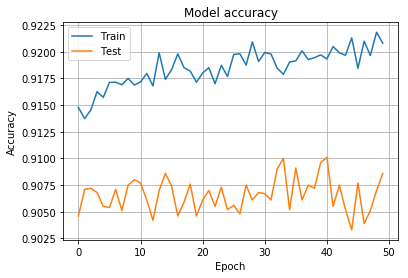

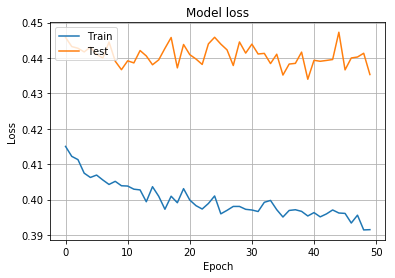

In [61]:
#history = model.fit(x_train, y_train, batch_size=batch_size, epochs=60, initial_epoch=31, verbose=1, validation_data=(x_test, y_test), callbacks=callbacks_list2)
history = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=batch_size),
                              steps_per_epoch=len(x_train) / batch_size, 
                              epochs=50,
                              verbose=1, validation_data=train_datagen.flow(x_test, y_test, batch_size=batch_size),
                              validation_steps=len(x_test) / batch_size,
                              callbacks=callbacks_list)

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
#K.set_value(model.optimizer.lr, 0.001)
print('learning rate after (125 + 62 + 62) 250 epochs is: ', K.get_value(sgd.lr))
#K.set_value(sgd.lr, 0.1 * K.get_value(sgd.lr))
#print('setting new learning rate: ', K.get_value(sgd.lr))

In [ ]:
#from google.colab import files
#files.download('DNST_model.h5')